# Introduction to the eqcatalog module

Matplotlib figure size configuration

In [87]:
#%matplotlib notebook
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (9, 9)

## Getting started

### Installing

The eqcatalog module is available on the seismo SVN server at the following address:

https://svn.seismo.oma.be/svn/seismo/eqcatalog/trunk

The eqcatalog module has the following dependencies:

- Python extension modules:
    - numpy, scipy, matplotlib
    - MySQLdb
    - osr and ogr (part of GDAL)
- ROB modules:
    - mapping.geo module, available at https://svn.seismo.oma.be/svn/seismo/mapping/geo/trunk
- Third-party modules:
    - hazardlib (formerly nhlib), part of OpenQuake, available at https://github.com/gem/oq-hazardlib
    - the methods analyse_completeness_Stepp, decluster, analyse_Mmax, and analyse_recurrence require mtoolkit, this is the hazard modellers toolkit, a side project of OpenQuake, available at https://github.com/gem/oq-hazard-modeller
- Other files:
    - all functionality related to source models (splitting into zone catalogs, plotting) require the osr and ogr modules (part of GDAL), and the availability of the corresponding MapInfo files in D:\GIS-data\KSB-ORB\Source Zone Models


### Importing

In [45]:
import datetime
from collections import OrderedDict
import eqcatalog

Query the database based on region, time, magnitude, focal depth or ID. Take care with the application of magnitude bounds, as earthquakes in the database have different magnitude types, and magnitudes are not converted to a common type. MW takes precedence over MS, which in turn takes precedence over ML.

In [44]:
region = (0, 8, 49, 52)
start_date = 1352
Mmin = None
catalog = eqcatalog.rob.query_local_eq_catalog(region=region, start_date=start_date, Mmin=Mmin, verbose=True)
print(catalog)

SELECT id_earth, DATE_FORMAT(date, "%Y-%m-%d") as date, TIME_FORMAT(time, "%H:%i:%s") as time, longitude, latitude, depth, ML, MS, MW, IF(MW, MW, IF(MS, MS, ML)) as M, intensity_max, macro_radius, errh, errz, errt, errM, name, type FROM earthquakes WHERE is_true = 1 and type = "ke" and longitude Between 0.000000 and 8.000000 and latitude Between 49.000000 and 52.000000 and date Between "1352-01-01" and "2018-12-27" ORDER BY date asc, time asc
<eqcatalog.eqcatalog.EQCatalog instance at 0x0000000014677D48>


In [41]:
catalog.print_report()

Name: ROB Catalog 1352-01-01 - 2018-12-27
Earthquake number: 2619
Start time: 1352-01-01T00:00:00
End time :  2018-12-27T00:00:00
ML: n=2149, min=-1.1, max=5.8
MW: n=3, min=4.0, max=5.3
MS: n=48, min=2.0, max=6.3
Longitude bounds: 0.8830 / 8.0000
Latitude bounds: 49.1630 / 51.9500
Depth range 0.0 - 42.6 km


The result is an EQCatalog object, which is a collection of LocalEarthquake objects.

## LocalEarthquake object

Select an earthquake by indexing the catalog:

In [43]:
eq = catalog[-2]
print(eq)

<eqcatalog.eqrecord.LocalEarthquake instance at 0x0000000009F10688>


LocalEarthquake has the following properties:
ID, datetime, (date), (time), lon, lat, depth, ML, MS, MW, name, intensity_max, macro_radius, errh, errz, errt, errM

In [80]:
print(eq.name, str(eq.date), str(eq.time), eq.ML, eq.MS, eq.MW, eq.depth)

(u'ROERMOND(N)', '1992-04-13', '01:20:02', 5.8, 5.4, 5.3, 19.0)


LocalEarthquake objects support magnitude conversion, with the relations specified as an ordered dictionary, which specifies their order of precedence. Note that specifying None will apply sensible default conversion relations.

In [48]:
Mrelation = OrderedDict([("MS", "Utsu2002"), ("ML", "ReamerHinzen2004Q")])
print(eq.get_MW(Mrelation))

5.3


Geographic functionality

In [49]:
Uccle = (4.3333, 50.8000)
print(eq.epicentral_distance(Uccle), eq.hypocentral_distance(Uccle))
print(eq.azimuth_to(Uccle), eq.azimuth_from(Uccle))

(72.78888713782466, 72.95362972987003)
(228.89252934877894, 48.28589519039599)


Upcoming: link to macroseismic data points, focal mechanism, ...

## EQCatalog object

### Processing parameters

In [81]:
Mtype = "MW"
Mrelation = OrderedDict([("MS", "Utsu2002"), ("ML", "ReamerHinzen2004Q")])
completeness = eqcatalog.rob.Completeness_MW_201303a
region = (-1.25, 8.75, 49.15, 53.30)
start_date = datetime.date(1350, 1, 1)
end_date = datetime.date(2018, 12, 31)

### Read raw catalog from database

In [51]:
raw_catalog = eqcatalog.rob.query_local_eq_catalog(region=region, Mmin=0.1, start_date=start_date, end_date=end_date)

### Getting information

Number of earthquakes

In [54]:
print(len(raw_catalog))

1871


Bounds

In [53]:
raw_catalog.print_report()

Name: ROB Catalog 1350-01-01 - 2014-12-31
Earthquake number: 1871
Start time: 1350-01-01T00:00:00
End time :  2014-12-31T00:00:00
ML: n=1839, min=0.1, max=5.8
MW: n=3, min=4.0, max=5.3
MS: n=49, min=2.0, max=6.3
Longitude bounds: -0.7700 / 8.7125
Latitude bounds: 49.1630 / 53.2501
Depth range 0.0 - 42.6 km


Total seismic moment, and moment rate

In [56]:
print(raw_catalog.get_M0(Mrelation=Mrelation))
print("%s N.m" % raw_catalog.get_M0_total(Mrelation=Mrelation))
print("%s N.m/yr" % raw_catalog.get_M0_rate(Mrelation=Mrelation))

[1.25797317e+18 3.00268590e+17 7.96083114e+16 ... 1.42007081e+13
 4.45656248e+11 7.82906682e+11]
8.290783805192214e+18 N.m
1.2467398590396206e+16 N.m/yr


In [57]:
help(raw_catalog.get_M0_total)

Help on method get_M0_total in module eqcatalog.eqcatalog:

get_M0_total(self, Mrelation=u'default') method of eqcatalog.eqcatalog.EQCatalog instance
    Compute total seismic moment.
    
    :param Mrelation:
            {str: str} dict, mapping name of magnitude conversion relation
            to magnitude type ("MS" or "ML")
            (default: None, will select the default relation for the given Mtype)
    
    :return:
            Float, total seismic moment in N.m



Plot map

Number of layers: 1
Fixing older MapInfo implementation of Lambert1972...
Number of features in layer 0: 14


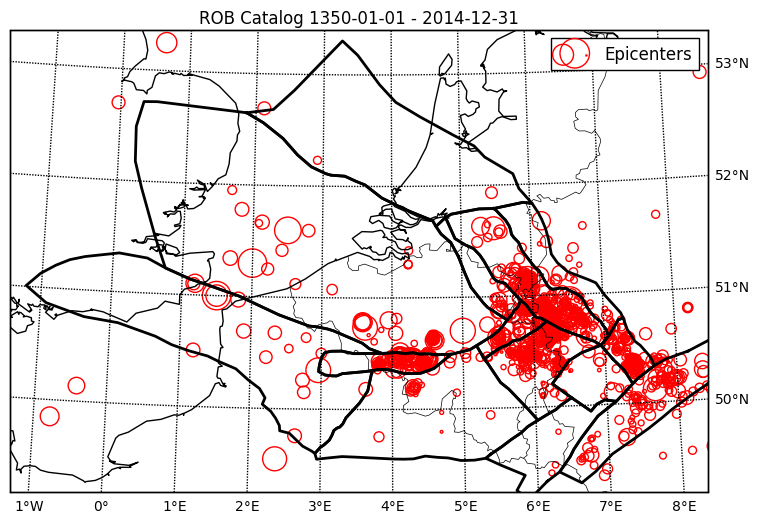

In [88]:
raw_catalog.plot_map(source_model="Seismotectonic", projection="laea", legend_location=1)

### Subselecting

By slicing or indexing

In [59]:
subcatalog = raw_catalog[-100:]
print(len(subcatalog))

100


In [60]:
subcatalog = raw_catalog[range(0, len(raw_catalog), 2)]
print(len(subcatalog))

936


Looping is of course supported too:

In [61]:
for eq in raw_catalog:
    if eq.MS:
        print(str(eq.date), eq.lon, eq.lat, eq.MS, eq.name)

('1382-05-21', 2.0, 51.3, 6.0, u'MER DU NORD')
('1449-04-23', 2.5, 51.6, 5.5, u'MER DU NORD')
('1504-08-23', 6.2, 50.8, 5.0, u'AIX')
('1580-04-06', 1.5, 51.0, 6.0, u'PAS DE CALAIS')
('1640-04-04', 6.2, 50.8, 5.5, u'AACHEN')
('1692-09-18', 5.86, 50.59, 6.3, u'VERVIERS')
('1755-12-26', 6.2, 50.8, 4.2, u'AACHEN')
('1755-12-27', 6.2, 50.8, 5.2, u'AACHEN')
('1755-12-27', 6.2, 50.8, 4.5, u'AACHEN')
('1756-02-14', 6.5, 50.8, 4.2, u'DUEREN AREA')
('1756-02-18', 6.5, 50.8, 5.7, u'DUEREN AREA')
('1756-02-19', 6.5, 50.8, 4.4, u'DUEREN AREA')
('1756-02-20', 6.5, 50.8, 4.5, u'DUEREN AREA')
('1756-02-21', 6.5, 50.8, 4.1, u'DUEREN AREA')
('1756-02-25', 6.5, 50.8, 4.3, u'DUEREN AREA')
('1756-04-30', 2.37, 49.55, 4.8, u'BRETEUIL')
('1756-06-03', 6.5, 50.8, 4.3, u'DUEREN AREA')
('1756-10-28', 6.5, 50.8, 3.7, u'DUEREN AREA')
('1756-11-19', 6.5, 50.8, 4.4, u'DUEREN AREA')
('1776-11-28', 1.5, 51.0, 4.1, u'PAS DE CALAIS')
('1828-02-23', 5.0, 50.7, 5.1, u'JAUCHE AREA')
('1828-12-03', 5.97, 50.42, nan, u'HAUT

('2010-05-09', 5.9778, 51.1438, nan, u'MONTFORT (NL)')
('2010-05-16', 5.9393, 50.3633, nan, u'WANNE (BE)')
('2010-05-16', 5.9372, 50.3442, nan, u'WANNE (BE)')
('2010-06-07', 5.9435, 51.1495, nan, u'MONTFORT (NL)')
('2010-06-07', 6.2352, 50.8523, nan, u'ESCHWEILER (DE)')
('2010-06-15', 6.4315, 50.6095, nan, u'HEIMBACH (DE)')
('2010-06-17', 6.3713, 50.7103, nan, u'HUERTGENWALD (DE)')
('2010-06-22', 6.6802, 50.932, nan, u'KENTEN (DE)')
('2010-06-29', 8.485, 50.0925, nan, u'HOFHEIM (DE)')
('2010-07-03', 4.3253, 50.1352, nan, u'FROIDCHAPELLE (BE)')
('2010-07-14', 6.3868, 50.825, nan, u'JUNGERSDORF (DE)')
('2010-08-01', 5.9662, 51.157, nan, u'MONTFORT (NL)')
('2010-08-10', 5.904, 51.1632, nan, u'MAASGOUW (NL)')
('2010-08-11', 6.0957, 50.7477, nan, u'AACHEN (DE)')
('2010-08-14', 7.6883, 50.184, nan, u'DAMSCHEID (DE)')
('2010-08-27', 7.9602, 49.8843, nan, u'GENSINGEN (DE)')
('2010-09-22', 7.7337, 50.1763, nan, u'ST-GOAR (DE)')
('2010-09-24', 7.8695, 50.1005, nan, u'SAUERTHAL (DE)')
('2010-10-0

Get a particular record by ID or by indexing

In [62]:
eq = raw_catalog.get_record(987)
print(eq.name, eq.ML, eq.MS, eq.MW)

(u'ROERMOND(N)', 5.8, 5.4, 5.3)


By region, time, magnitude, depth

In [64]:
historical_catalog = raw_catalog.subselect(end_date=1910)
print(len(historical_catalog))
print(historical_catalog.Mminmax(Mtype=Mtype))
historical_catalog.print_list()

28
(4.0, 6.063333333333333)
+-----+------------+----------+---------------------+---------+---------+-------+-----+-----+-----+
|  ID |    Date    |   Time   |         Name        |   Lon   |   Lat   | Depth |  ML |  MS |  MW |
+-----+------------+----------+---------------------+---------+---------+-------+-----+-----+-----+
|  57 | 1382-05-21 | 13:00:00 |     MER DU NORD     |  2.0000 | 51.3000 |  0.0  | nan | 6.0 | nan |
|  63 | 1449-04-23 | 04:00:00 |     MER DU NORD     |  2.5000 | 51.6000 |  0.0  | nan | 5.5 | nan |
|  66 | 1504-08-23 | 23:00:00 |         AIX         |  6.2000 | 50.8000 |  0.0  | nan | 5.0 | nan |
|  78 | 1580-04-06 | 18:00:00 |    PAS DE CALAIS    |  1.5000 | 51.0000 |  0.0  | nan | 6.0 | nan |
|  81 | 1640-04-04 | 03:30:00 |        AACHEN       |  6.2000 | 50.8000 |  0.0  | nan | 5.5 | nan |
|  89 | 1692-09-18 | 14:30:00 |       VERVIERS      |  5.8600 | 50.5900 |  0.0  | nan | 6.3 | nan |
| 107 | 1755-12-26 | 16:00:00 |        AACHEN       |  6.2000 | 50.8000 

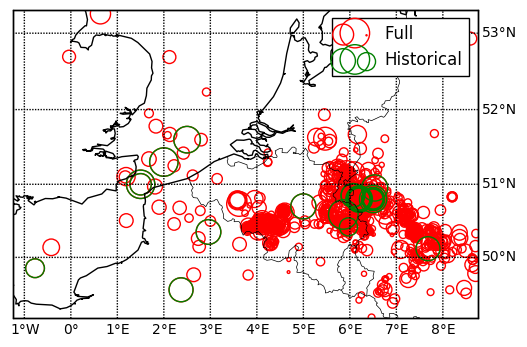

In [65]:
eqcatalog.plot_catalogs_map([raw_catalog, historical_catalog], labels=["Full", "Historical"], legend_location=1)

### Split catalog according to source-zone model (requires GDAL module and MapInfo tables in GIS-data folder)

In [66]:
source_model_name = "Seismotectonic"
zone_catalogs = raw_catalog.split_into_zones(source_model_name, verbose=False)
for zone_id, zone_catalog in zone_catalogs.items():
    print(zone_id, len(zone_catalog))

Fixing older MapInfo implementation of Lambert1972...
('RVG', 522)
('LGZ', 86)
('EAM', 423)
('MOB', 183)
('PVZ', 24)
('ABM', 234)
('WAZ', 17)
('WAM', 25)
('ECZ', 22)
('WNB', 2)
('NB', 173)
('HTM', 97)
('EZ', 15)
('TG', 3)


Number of layers: 1
Fixing older MapInfo implementation of Lambert1972...
Number of features in layer 0: 14


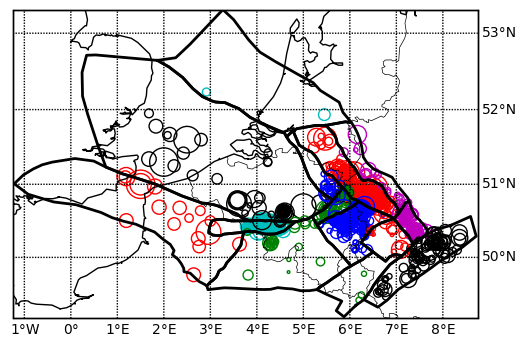

In [67]:
eqcatalog.plot_catalogs_map(zone_catalogs.values(), source_model=source_model_name, labels=[""]*len(zone_catalogs), region=region)

Number of layers: 1
Fixing older MapInfo implementation of Lambert1972...
Number of features in layer 0: 14


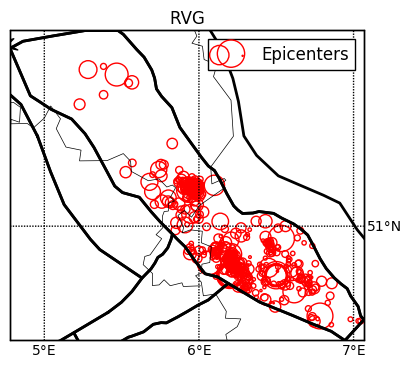

In [68]:
zone_catalogs["RVG"].plot_map(source_model=source_model_name)

### Declustering

In [69]:
method = "Cluster"
window = "Uhrhammer1986"
fa_ratio = 0.5

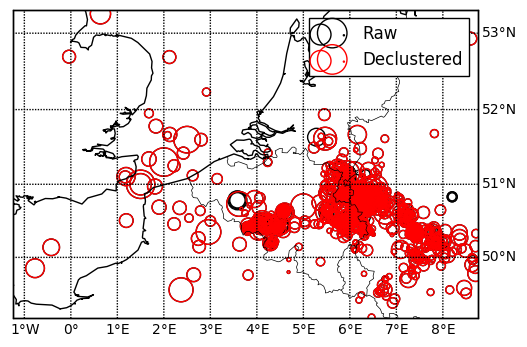

In [70]:
dc_catalog = raw_catalog.subselect_declustering(method=method, window=window, fa_ratio=fa_ratio, Mtype=Mtype, Mrelation=Mrelation)
eqcatalog.plot_catalogs_map([raw_catalog, dc_catalog], edge_colors=['k', 'r'], labels=["Raw", "Declustered"], legend_location=1)

In [71]:
rvg_catalog = zone_catalogs["RVG"]
main_shocks = rvg_catalog.subselect_declustering(method=method, window=window, fa_ratio=fa_ratio, Mtype=Mtype, Mrelation=Mrelation)
print(len(rvg_catalog), len(main_shocks))

(522, 400)


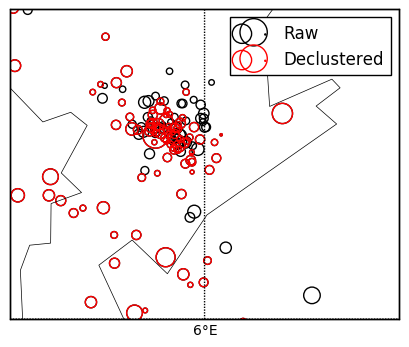

In [72]:
eqcatalog.plot_catalogs_map([rvg_catalog, main_shocks], edge_colors=['k', 'r'], labels=["Raw", "Declustered"], region=(5.75, 6.25, 51., 51.25))

### Apply completeness

In [73]:
cc_catalog = dc_catalog.subselect_completeness(Mtype=Mtype, Mrelation=Mrelation, completeness=completeness)
print(len(cc_catalog))

Number of events constrained by completeness criteria: 401 out of 1458
401


AttributeError: 'numpy.datetime64' object has no attribute 'year'

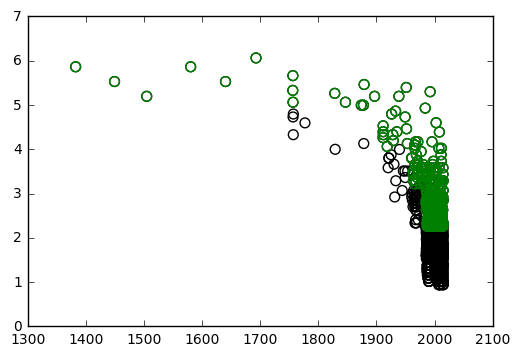

In [74]:
eqcatalog.plot_catalogs_magnitude_time([dc_catalog, cc_catalog], labels=["Declustered", "CC"], edge_colors=['k', 'g'], completeness=completeness)

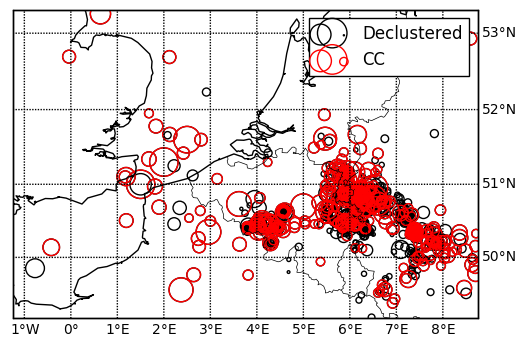

In [75]:
eqcatalog.plot_catalogs_map([dc_catalog, cc_catalog], labels=["Declustered", "CC"], edge_colors=['k', 'r'])

### Analyse magnitude-frequency distribution

Observed MFD

In [76]:
Mmin = 2.2
Mmax = 7.2
bin_width = 0.1

Number of events constrained by completeness criteria: 401 out of 401


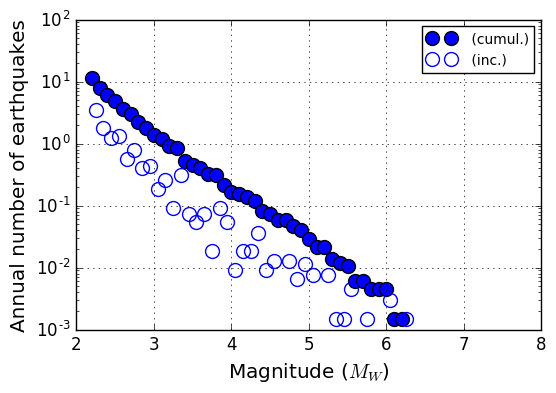

In [77]:
observed_mfd = cc_catalog.get_incremental_MFD(Mmin, Mmax, bin_width, Mtype=Mtype, Mrelation=Mrelation, completeness=completeness)
observed_mfd.plot(color='b')

Compute Gutenberg-Richter MFD using the method by Weichert (1980)

Number of events constrained by completeness criteria: 401 out of 401
Maximum-likelihood estimation (Weichert)
BETA=2.349 +/- 0.075; B=1.020 +/- 0.033
Total number of events: 401
LOG(annual rate above M0): 3.350
Annual rate above M5: 0.018 +/- 0.001
Annual rate above M0: 2239.471 +/- 111.834


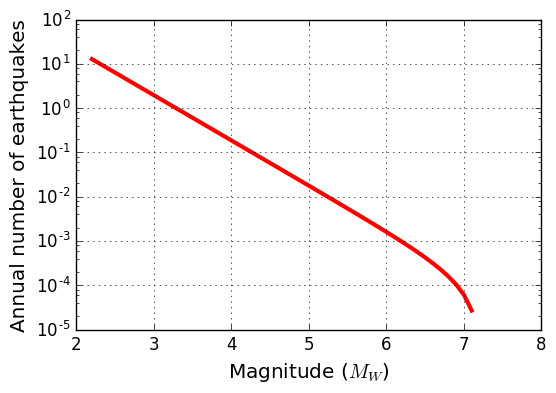

In [78]:
estimated_mfd = cc_catalog.get_estimated_MFD(Mmin, Mmax, bin_width, method="Weichert", Mtype=Mtype, Mrelation=Mrelation, completeness=completeness, verbose=True)
estimated_mfd.plot(color='r')

Both together

Number of events constrained by completeness criteria: 401 out of 401


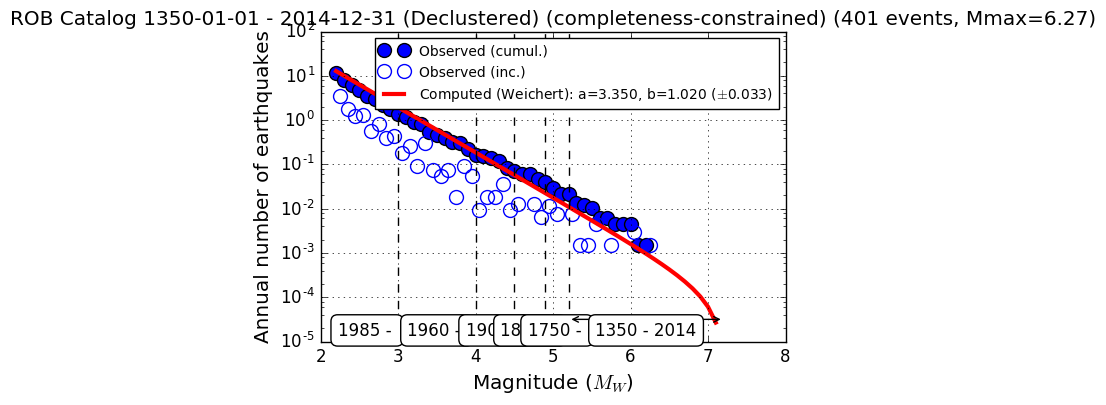

In [79]:
cc_catalog.plot_MFD(Mmin, Mmax, bin_width, method="Weichert", Mtype=Mtype, Mrelation=Mrelation, completeness=completeness)